In [1]:
from pathlib import Path

import pandas as pd
import inspect

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics, get_tester
from neuralhydrology.nh_run import start_run
from neuralhydrology.utils.config import Config

In [3]:
import neuralhydrology.modelzoo
print(inspect.getfile(neuralhydrology.modelzoo.get_model))

d:\github\neuralhydrology\neuralhydrology\neuralhydrology\modelzoo\__init__.py


In [7]:
# by default we assume that you have at least one CUDA-capable NVIDIA GPU or MacOS with Metal support
if torch.cuda.is_available() or torch.backends.mps.is_available():
    start_run(config_file=Path("1_basin.yml"))

# fall back to CPU-only mode
else:
    start_run(config_file=Path("1_basin.yml"), gpu=-1)

2025-05-01 02:23:38,376: Logging to d:\github\neuralhydrology\neuralhydrology\own\testruns\runs\test_run_0105_022338\output.log initialized.
2025-05-01 02:23:38,377: ### Folder structure created at d:\github\neuralhydrology\neuralhydrology\own\testruns\runs\test_run_0105_022338
2025-05-01 02:23:38,377: ### Run configurations for test_run
2025-05-01 02:23:38,378: experiment_name: test_run
2025-05-01 02:23:38,378: use_frequencies: ['1h', '1D']
2025-05-01 02:23:38,379: train_basin_file: 1_basin.txt
2025-05-01 02:23:38,380: validation_basin_file: 1_basin.txt
2025-05-01 02:23:38,380: test_basin_file: 1_basin.txt
2025-05-01 02:23:38,381: train_start_date: 1999-10-01 00:00:00
2025-05-01 02:23:38,382: train_end_date: 2008-09-30 00:00:00
2025-05-01 02:23:38,382: validation_start_date: 1996-10-01 00:00:00
2025-05-01 02:23:38,383: validation_end_date: 1999-09-30 00:00:00
2025-05-01 02:23:38,384: test_start_date: 1989-10-01 00:00:00
2025-05-01 02:23:38,385: test_end_date: 1996-09-30 00:00:00
2025-

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001DCAA1E4160>
Traceback (most recent call last):
  File "c:\Users\Workstation\anaconda3\envs\neuralhydrology\lib\site-packages\torch\utils\data\dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "c:\Users\Workstation\anaconda3\envs\neuralhydrology\lib\site-packages\torch\utils\data\dataloader.py", line 1576, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


KeyboardInterrupt: 

In [4]:
run_dir = Path("runs/test_run_2504_020929")  # you'll find this path in the output of the training above.
run_config = Config(Path("1_basin.yml"))

# create a tester instance and start evaluation
tester = get_tester(cfg=Config(run_dir / "config.yml"), run_dir=run_dir, period="test", init_model=True)
results = tester.evaluate(save_results=False, metrics=run_config.metrics)

results.keys()

2025-05-01 02:16:25,377: No specific hidden size for frequencies are specified. Same hidden size is used for all.
2025-05-01 02:16:25,401: Using the model weights from runs\test_run_2504_020929\model_epoch050.pt
# Evaluation: 100%|██████████| 5/5 [00:19<00:00,  3.87s/it]


dict_keys(['01022500', '01047000', '01162500', '06409000', '08171300'])

Daily metrics:
  NSE: 0.782
  MSE: 0.003
  RMSE: 0.050
  KGE: 0.813
  Alpha-NSE: 0.853
  Beta-KGE: 1.011
  Beta-NSE: 0.011
  Pearson-r: 0.885
  FHV: -17.749
  FMS: -10.197
  FLV: 49.586
  Peak-Timing: 0.625
  Peak-MAPE: 25.592


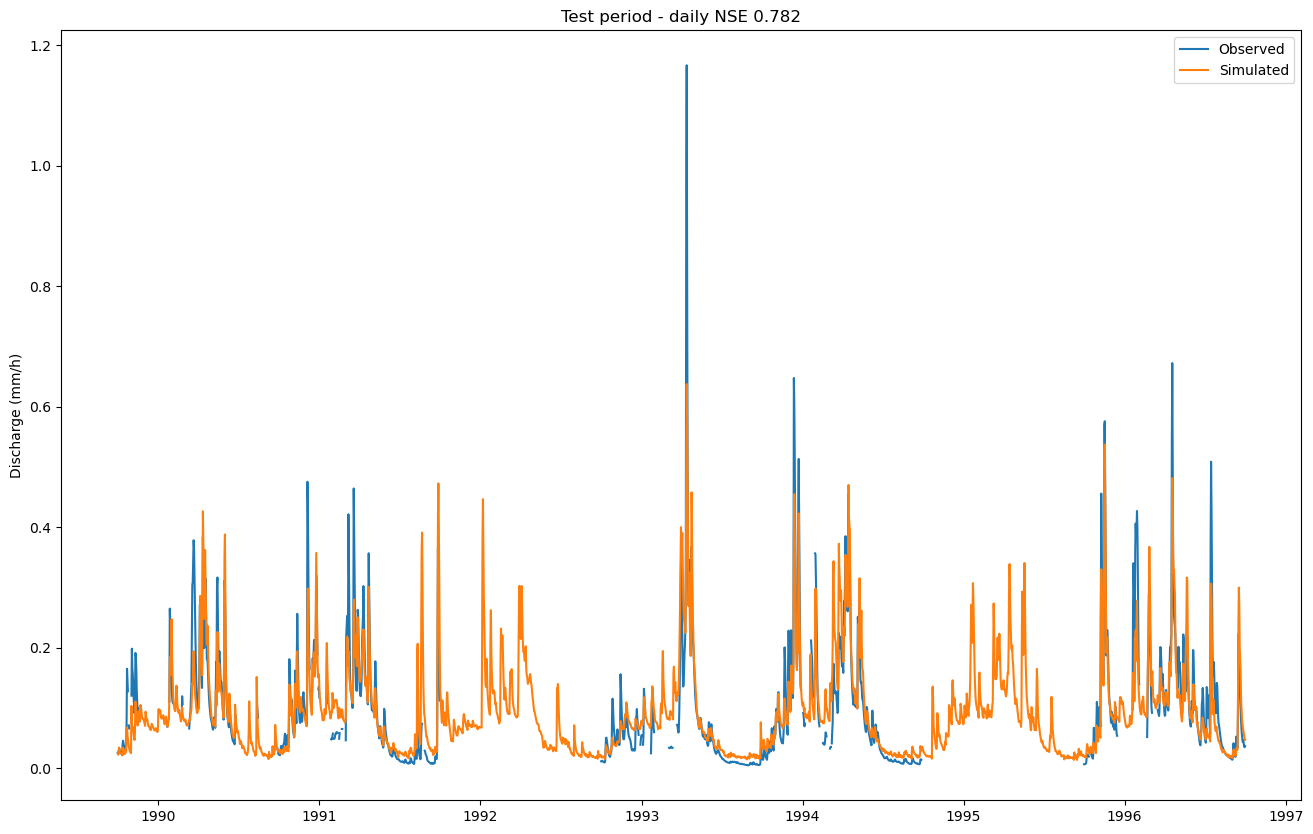

In [5]:
# extract observations and simulations
daily_qobs = results["01022500"]["1D"]["xr"]["QObs(mm/h)_obs"]
daily_qsim = results["01022500"]["1D"]["xr"]["QObs(mm/h)_sim"]

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(daily_qobs["date"], daily_qobs, label="Observed")
ax.plot(daily_qsim["date"], daily_qsim, label="Simulated")
ax.legend()
ax.set_ylabel("Discharge (mm/h)")
ax.set_title(f"Test period - daily NSE {results['01022500']['1D']['NSE_1D']:.3f}")

# Calculate some metrics
values = metrics.calculate_all_metrics(daily_qobs.isel(time_step=-1), daily_qsim.isel(time_step=-1))
print("Daily metrics:")
for key, val in values.items():
    print(f"  {key}: {val:.3f}")

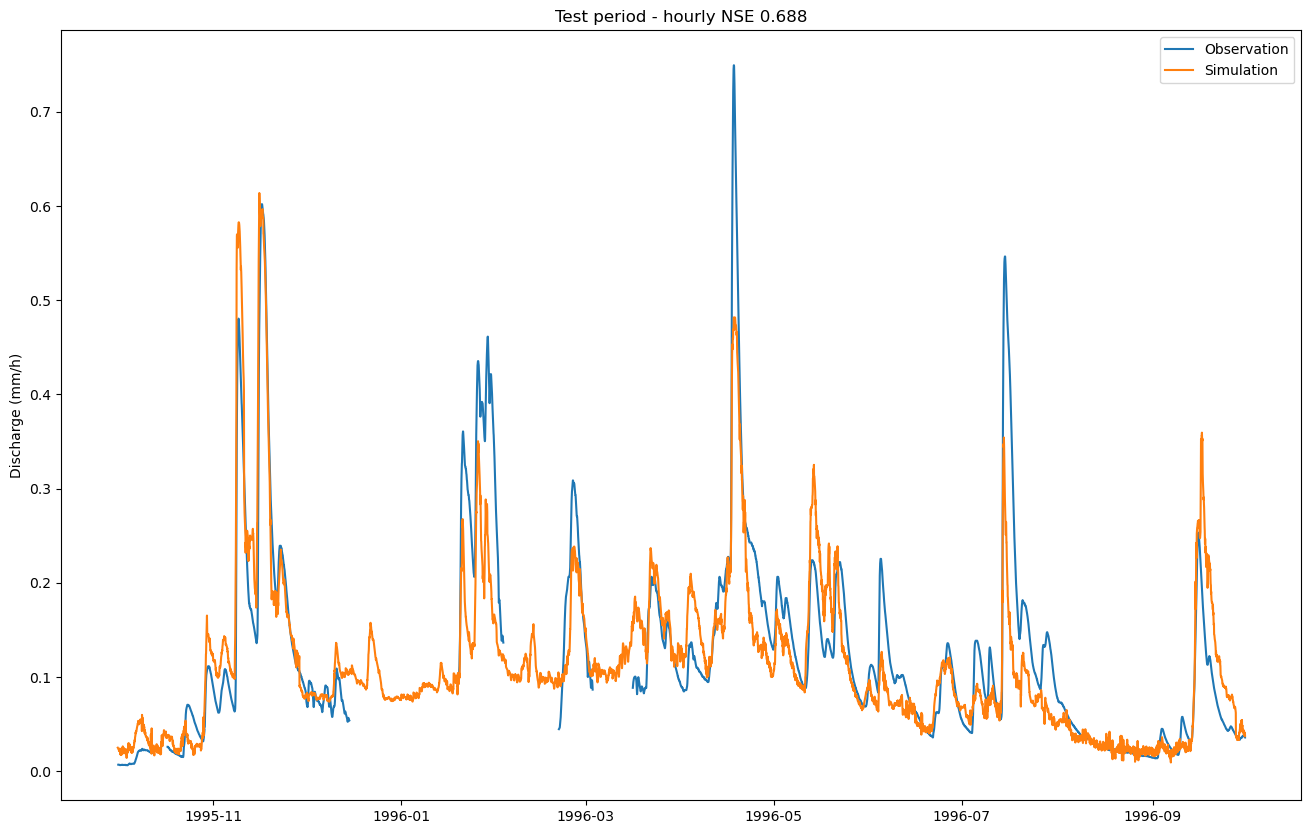

In [6]:
# Extract a date slice of observations and simulations
hourly_xr = results["01022500"]["1h"]["xr"].sel(date=slice("10-1995", None))

# The hourly data is indexed with two indices: The date (in days) and the time_step (the hour within that day).
# As we want to get a continuous plot of several days' hours, we select all 24 hours of each day and then stack
# the two dimensions into one consecutive datetime dimension.
hourly_xr = hourly_xr.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])

# Reset the MultiIndex to avoid conflicts
hourly_xr = hourly_xr.reset_index('datetime')

# Assign the new continuous 'datetime' coordinate
hourly_xr = hourly_xr.assign_coords(
    datetime=hourly_xr['date'] + pd.to_timedelta(hourly_xr['time_step'], unit='h')
)

# Extract observation and simulation data
hourly_qobs = hourly_xr["QObs(mm/h)_obs"]
hourly_qsim = hourly_xr["QObs(mm/h)_sim"]

# Plot the data
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(hourly_qobs["datetime"], hourly_qobs, label="Observation")
ax.plot(hourly_qsim["datetime"], hourly_qsim, label="Simulation")
ax.set_ylabel("Discharge (mm/h)")
ax.set_title(f"Test period - hourly NSE {results['01022500']['1h']['NSE_1h']:.3f}")
ax.legend()

plt.show()